## Laboratoire 2
**Equipe 1** 



Membres: Kevin Chenier, Jeremie Bellegarde, Sebastien René


## Introduction

 Pour ce laboratoire, nous devons choisir 8 classes pour créer un ensemble d'images qui pourront être reconnu grâce aux notions que nous avons apprisent en classe.
 Pour ce faire, nous utiliserons Jupyter Notebook afin de séparer clairement chacune des étapes que nous deverons accomplir.
 Nous allons faire par nous même un réseau de neuronne et par la suite, utiliser des modeles déjà existant afin de comparer nos résultats. Ceci nous permettera de tirer une conclusion sur les forces et faiblesses de différents modèles.
 

## Importation des librairies nécéssaires

Les librairies qui nous seront nécéssaire pour le traitement des images sont les suivantes :


In [60]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neural_network import MLPClassifier

## Augmentation des données

Voici le code utilisé pour l'augmentation des données. Ce code consiste à créer des nouvelles images à partir des images existantes en effectuant des opérations tel que, par exemple, la rotation. Le but de cette opération est d'avoir plus d'image pour notre echantillon.

In [61]:
def dataset_augmentation(path, nb_imgs):
    # Path to the image dataset
    p = Augmentor.Pipeline(str(path), output_directory=".")

    # Operations to be performed on the images:
    p.rotate90(probability=0.2)
    p.rotate270(probability=0.2)
    p.flip_left_right(probability=0.30)
    p.flip_top_bottom(probability=0.30)
    p.skew_tilt(probability=0.25, magnitude=0.1)
    p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)

    # Specifyin the number of images to generate
    p.sample(nb_imgs)
    
    print({path}, ": augmentation done for", {nb_imgs}, "more images.")

## Choix du Dataset pour l'ensemble B

Voici notre choix d'images pour l'ensemble B. Cet ensemble est constitué de 8 symboles:

In [62]:
# Define the base data directory path
data_dir = Path.cwd() / "EnsembleB_H2020"

# A list of string with all the categories/labels in your database, i.e., each class subfolder name
CLASSES = [
    {
        "LABEL": "Cercle2", 
        "GROUP": 0,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle2')
    },
    {
        "LABEL": "Cercle3", 
        "GROUP": 1,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle3')
    },
    {
        "LABEL": "Diamant2",
        "GROUP": 2,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant2')
    },
    {
        "LABEL":"Diamant3", 
        "GROUP": 3,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant3')
    },
    {
        "LABEL":"Hexagone2", 
        "GROUP": 4,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone2')
    },
    {
        "LABEL":"Hexagone3", 
        "GROUP": 5,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone3')
    },
    {
        "LABEL":"Triangle2", 
        "GROUP": 6,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle3", 
        "GROUP": 7,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle3')
    }
]

## Pretraitement des images

Nous avons commencé par redimmensionner les images, pour ensuite leur appliqué un filtre pour les rendre grises et pour les rendre flous. Les opérations qui nous ont permi d'avoir le plus d'amélioration selon nos test était l'application du filtre pour le flou et du filtre pour le gris. Nous en avous aussi profité pour redimensionner l'image tel que demandé dans l'ennoncé.

In [63]:
imageSize = (160, 160)

dataSet = []

# Read all the files and append to dataset
for CLASS in CLASSES:
    print(f"=> Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        gray = cv2.resize(gray, imageSize)
        
        # Calculate contours
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        # Save the polygons
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            polygons.append(len(approximation))
        
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # Create a data variable to add to dataSet
        data = {
            'image': gray,
            'label': CLASS['GROUP'],
            'polygons': polygons,
            'feature': feature
        }
        
        # Append data to dataSet
        dataSet.append(data)   

=> Reading files from class Cercle2



=> Reading files from class Cercle3



=> Reading files from class Diamant2



=> Reading files from class Diamant3



=> Reading files from class Hexagone2



=> Reading files from class Hexagone3



=> Reading files from class Triangle2



=> Reading files from class Triangle3


In [64]:
# Shuffle pictures
random.shuffle(dataSet)

# create X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating files containing all the information about your model and saving them
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Machine learning training

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

In [66]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [67]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [68]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Réseau Neuronal

Voici notre modèle pour le Réseau Neuronal. Nous nous sommes basé sur la théorie vue en classe pour le faire. Une fois le modèle en place, nous avons essayer avec des hyperparamètres différents tel que le learning rate, le nombre de couches cachées ou un nombre d'itérations (epoch) plus ou moins élevé. Nous avons laissé comme données les hyperparamètre pour lesquels nous semblions avoir le plus de succès. 

    Nos hyperparamètre finaux sont les suivants:   epoch = 3000
                                                   couche caché = 50
                                                   learning rate = 0.01
                                                


In [86]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

In [70]:
class NeuralNetwork:

    def __init__(self, n_classes, n_features, n_hidden_units=15, epochs=300,
                 learning_rate=0.01, n_batches=1):
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def error(self, y, output):
        error = -np.sum(y*np.log(output))
        return 0.5 * np.mean(error)

    def weights(self):
        w1 = np.random.rand(self.n_hidden_units, self.n_features)
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)
        return w1, w2

    def forward_step(self, X):
        z1 = np.dot(self.w1,X.T)
        hidden_output = sigmoid(z1)
        z2 = np.dot(self.w2,hidden_output)
        final_output = sigmoid(z2)
        return z1, hidden_output, z2, final_output

    def backward_step(self, X, z1, hidden_output, final_output, y):
        output_error = final_output - y
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)
        grad1 = output_delta.dot(X)
        grad2 = output_error.dot(hidden_output.T)
        return grad1, grad2

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        y = y.T
        grad1, grad2 = self.backward_step(X, z1, hidden_output, final_output, y)
        error = self.error(y, final_output)
        return error, grad1, grad2

    def fit(self, X, y):
        self.error_ = []
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)

        X_batches = np.array_split(X, self.n_batches)
        y_batches = np.array_split(y, self.n_batches)

        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_batches, y_batches):
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self

    def predict(self, X):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        return np.argmax(z2.T, 1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [71]:
nn = NeuralNetwork(
    n_classes=8, 
    n_features=len(X[0]),
    n_hidden_units=50,
    epochs=3000,
    learning_rate=0.01,
    n_batches=30,
).fit(X_train, y_train);

0 22.748712177338074
1 26.690754042370365
2 26.476016068908386
3 26.25371539954205
4 26.020190993957506
5 25.77310494859647
6 25.511612095607983
7 25.236522169442306
8 24.950354207397133
9 24.657186112300483
10 24.362246042389536
11 24.071277353492007
12 23.789803173751725
13 23.52246765487264
14 23.272604811462706
15 23.042098318451632
16 22.83149850668349
17 22.640302310462236
18 22.46729146157957
19 22.310848850046572
20 22.169209388772053
21 22.040633130977064
22 21.92350817310969
23 21.81639959451497
24 21.718061877859068
25 21.627429590751376
26 21.54359720046065
27 21.465795176566836
28 21.39336659175778
29 21.325746352787185
30 21.262443858320736
31 21.203029102014774
32 21.14712184201793
33 21.09438330238349
34 21.044509856679458
35 20.99722820142368
36 20.952291613951875
37 20.909476980810346
38 20.868582365541368
39 20.829424953161386
40 20.791839261588898
41 20.755675549040983
42 20.72079837334542
43 20.687085276832153
44 20.654425581418845
45 20.62271928475145
46 20.591876

371 16.83848886969618
372 16.830471881077123
373 16.82248272623526
374 16.81452149905048
375 16.806588286248484
376 16.79868316749944
377 16.790806215520863
378 16.782957496184604
379 16.77513706862759
380 16.76734498536608
381 16.75958129241312
382 16.751846029398955
383 16.744139229694042
384 16.736460920534533
385 16.72881112314979
386 16.72118985289178
387 16.71359711936601
388 16.706032926563807
389 16.698497272995603
390 16.690990151825044
391 16.683511551003672
392 16.676061453405836
393 16.66863983696379
394 16.661246674802566
395 16.653881935374493
396 16.6465455825932
397 16.63923757596675
398 16.631957870729906
399 16.624706417975183
400 16.617483164782612
401 16.610288054348008
402 16.6031210261096
403 16.59598201587293
404 16.588870955933746
405 16.58178777519895
406 16.574732399305372
407 16.56770475073627
408 16.560704748935528
409 16.553732310419402
410 16.546787348885804
411 16.539869775321
412 16.53297949810372
413 16.52611642310662
414 16.519280453795055
415 16.51247

806 14.891226370018389
807 14.888228924366121
808 14.885233587393362
809 14.882240343839147
810 14.87924917852396
811 14.876260076350217
812 14.873273022302726
813 14.870288001449174
814 14.867304998940577
815 14.86432400001179
816 14.861344989981967
817 14.858367954255048
818 14.855392878320236
819 14.852419747752466
820 14.849448548212887
821 14.846479265449325
822 14.843511885296744
823 14.840546393677705
824 14.83758277660283
825 14.834621020171229
826 14.831661110570938
827 14.828703034079364
828 14.825746777063662
829 14.82279232598118
830 14.819839667379812
831 14.8168887878984
832 14.813939674267088
833 14.810992313307663
834 14.808046691933907
835 14.805102797151859
836 14.802160616060181
837 14.799220135850362
838 14.796281343807028
839 14.793344227308113
840 14.790408773825147
841 14.787474970923366
842 14.784542806261916
843 14.781612267593975
844 14.778683342766863
845 14.775756019722136
846 14.772830286495612
847 14.769906131217416
848 14.76698354211199
849 14.76406250749

1184 13.813876221917814
1185 13.810938806055756
1186 13.807999864823058
1187 13.805059395480923
1188 13.80211739537614
1189 13.799173861940742
1190 13.796228792691636
1191 13.793282185230213
1192 13.79033403724201
1193 13.787384346496301
1194 13.784433110845724
1195 13.78148032822592
1196 13.77852599665513
1197 13.77557011423381
1198 13.772612679144261
1199 13.76965368965023
1200 13.766693144096518
1201 13.763731040908606
1202 13.760767378592265
1203 13.757802155733165
1204 13.754835370996496
1205 13.751867023126575
1206 13.748897110946482
1207 13.745925633357649
1208 13.74295258933952
1209 13.739977977949142
1210 13.737001798320806
1211 13.73402404966567
1212 13.731044731271412
1213 13.728063842501827
1214 13.725081382796494
1215 13.722097351670406
1216 13.719111748713628
1217 13.71612457359092
1218 13.713135826041412
1219 13.710145505878254
1220 13.70715361298827
1221 13.704160147331631
1222 13.701165108941511
1223 13.698168497923772
1224 13.695170314456634
1225 13.692170558790341
12

1567 12.604785488974176
1568 12.60155325275137
1569 12.598321320585502
1570 12.595089693797926
1571 12.591858373658466
1572 12.588627361386417
1573 12.585396658151563
1574 12.582166265075236
1575 12.57893618323141
1576 12.575706413647767
1577 12.57247695730684
1578 12.569247815147174
1579 12.566018988064476
1580 12.562790476912818
1581 12.559562282505858
1582 12.556334405618072
1583 12.55310684698602
1584 12.549879607309618
1585 12.546652687253435
1586 12.54342608744802
1587 12.540199808491252
1588 12.536973850949662
1589 12.533748215359838
1590 12.530522902229794
1591 12.527297912040403
1592 12.524073245246784
1593 12.520848902279766
1594 12.517624883547326
1595 12.514401189436052
1596 12.51117782031264
1597 12.507954776525345
1598 12.504732058405505
1599 12.501509666269065
1600 12.498287600418045
1601 12.495065861142134
1602 12.491844448720144
1603 12.488623363421626
1604 12.485402605508378
1605 12.482182175236012
1606 12.478962072855483
1607 12.475742298614689
1608 12.47252285275999

1962 11.376718062987818
1963 11.373836608893905
1964 11.370956742110414
1965 11.36807846378326
1966 11.365201775037361
1967 11.362326676976794
1968 11.359453170684983
1969 11.356581257224892
1970 11.353710937639201
1971 11.350842212950502
1972 11.347975084161478
1973 11.345109552255083
1974 11.342245618194749
1975 11.33938328292458
1976 11.336522547369507
1977 11.333663412435522
1978 11.330805879009835
1979 11.327949947961075
1980 11.325095620139509
1981 11.32224289637718
1982 11.319391777488136
1983 11.316542264268632
1984 11.313694357497301
1985 11.310848057935335
1986 11.308003366326703
1987 11.305160283398353
1988 11.302318809860356
1989 11.299478946406136
1990 11.296640693712666
1991 11.29380405244064
1992 11.29096902323466
1993 11.288135606723456
1994 11.285303803520057
1995 11.282473614221963
1996 11.279645039411372
1997 11.276818079655351
1998 11.273992735506017
1999 11.271169007500736
2000 11.268346896162303
2001 11.265526401999134
2002 11.26270752550545
2003 11.25989026716145

2315 10.459550997770236
2316 10.457231068953186
2317 10.454912627783981
2318 10.452595673130562
2319 10.450280203857147
2320 10.447966218824257
2321 10.445653716888753
2322 10.443342696903905
2323 10.441033157719396
2324 10.438725098181388
2325 10.436418517132562
2326 10.434113413412144
2327 10.43180978585597
2328 10.42950763329651
2329 10.427206954562909
2330 10.424907748481038
2331 10.422610013873536
2332 10.420313749559858
2333 10.41801895435628
2334 10.41572562707599
2335 10.413433766529103
2336 10.411143371522696
2337 10.408854440860877
2338 10.406566973344793
2339 10.404280967772706
2340 10.401996422940003
2341 10.39971333763925
2342 10.39743171066024
2343 10.395151540790023
2344 10.392872826812967
2345 10.390595567510749
2346 10.38831976166246
2347 10.386045408044614
2348 10.383772505431157
2349 10.381501052593574
2350 10.379231048300884
2351 10.376962491319683
2352 10.374695380414186
2353 10.372429714346291
2354 10.37016549187557
2355 10.367902711759355
2356 10.365641372752748


2667 9.725700980863776
2668 9.723825959866357
2669 9.72195198015447
2670 9.720079040556099
2671 9.718207139900379
2672 9.71633627701763
2673 9.714466450739337
2674 9.712597659898188
2675 9.710729903328042
2676 9.70886317986397
2677 9.706997488342223
2678 9.705132827600298
2679 9.703269196476874
2680 9.701406593811862
2681 9.699545018446399
2682 9.69768446922287
2683 9.69582494498487
2684 9.693966444577276
2685 9.69210896684619
2686 9.690252510638995
2687 9.68839707480433
2688 9.686542658192113
2689 9.684689259653547
2690 9.682836878041122
2691 9.680985512208618
2692 9.679135161011123
2693 9.677285823305047
2694 9.6754374979481
2695 9.67359018379933
2696 9.671743879719125
2697 9.669898584569204
2698 9.668054297212642
2699 9.666211016513865
2700 9.664368741338674
2701 9.662527470554254
2702 9.660687203029143
2703 9.658847937633306
2704 9.657009673238091
2705 9.65517240871625
2706 9.653336142941965
2707 9.651500874790843
2708 9.649666603139913
2709 9.647833326867676
2710 9.646001044854057

In [72]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 79.30%


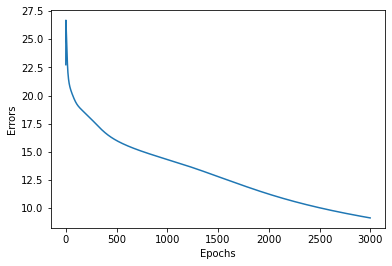

In [73]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.show()
    
plot_error(nn)

In [74]:
y_train_prediction = nn.predict(X_train)
y_test_prediction = nn.predict(X_test)
y_prediction = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [75]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[ 91   7   0   2   4   3   2   1]
 [  3 104   0   0   2   3   2   0]
 [ 10   0  60   4   8   5   5   3]
 [  2   2   1  69   1  10   1   2]
 [  5   2   1   3  75   7   1   1]
 [  1   4   0   1   1  76   0   0]
 [  1   0   6   2   3   0  90   1]
 [  1   0   3  14   2   5  11  44]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       110
           1       0.87      0.91      0.89       114
           2       0.85      0.63      0.72        95
           3       0.73      0.78      0.75        88
           4       0.78      0.79      0.79        95
           5       0.70      0.92      0.79        83
           6       0.80      0.87      0.84       103
           7       0.85      0.55      0.67        80

    accuracy                           0.79       768
   macro avg       0.80      0.79      0.78       768
weighted avg       0.80      0.79      0.79       768



### Matrice de confusion ensemble "test"

In [76]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[10 30  0  3  1  0  0  1]
 [ 4 18  0  1  0  5  3  0]
 [ 5  2  4  2  1  1  0  1]
 [ 0  2  1 13  2  6  3  2]
 [ 0  6  0  7  3 12  3  2]
 [ 2  9  0  3  1  7  1  0]
 [ 3  4  4  9  3  1 12  4]
 [ 0  2  2 12  2  1  1  4]]
              precision    recall  f1-score   support

           0       0.42      0.22      0.29        45
           1       0.25      0.58      0.35        31
           2       0.36      0.25      0.30        16
           3       0.26      0.45      0.33        29
           4       0.23      0.09      0.13        33
           5       0.21      0.30      0.25        23
           6       0.52      0.30      0.38        40
           7       0.29      0.17      0.21        24

    accuracy                           0.29       241
   macro avg       0.32      0.30      0.28       241
weighted avg       0.33      0.29      0.28       241



### Matrice de confusion ensemble "Val"

In [77]:
print(confusion_matrix(y_val,y_prediction))
print(classification_report(y_val,y_prediction))

[[16  2  0  6  1  1  2  1]
 [ 2 18  2  2  3  3  0  0]
 [ 1  1  6  6  1  1  2  1]
 [ 2  3  0 16  3  1  1  2]
 [ 1  2  0  0  6  7  3  0]
 [ 0  1  0  0  3 18  0  1]
 [ 0  0  4  4  1  2  9  1]
 [ 0  0  3 11  1  3  2  4]]
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        29
           1       0.67      0.60      0.63        30
           2       0.40      0.32      0.35        19
           3       0.36      0.57      0.44        28
           4       0.32      0.32      0.32        19
           5       0.50      0.78      0.61        23
           6       0.47      0.43      0.45        21
           7       0.40      0.17      0.24        24

    accuracy                           0.48       193
   macro avg       0.48      0.47      0.46       193
weighted avg       0.50      0.48      0.47       193



## Support Vector Machine (SVM lineair)

In [78]:
svc = SVC(cache_size=1500)
parameter = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10], 'class_weight': ['balanced'], 'gamma': ['scale']}
classifier = GridSearchCV(svc, param_grid = parameter, cv = 10, n_jobs = 5, scoring = 'accuracy', verbose=4)
classifier.fit(X_train, y_train)
print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (classifier.best_params_, classifier.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.58


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    1.2s finished


Nous avons constaté qu'augmenter la grosseur de la cache ne changeait pas nos résultats, alors nous l'avons gardé à 1500.

In [79]:
SVMaccuracy = pd.DataFrame(classifier.cv_results_['mean_test_score'], index = [x['C'] for x  in classifier.cv_results_['params']], columns = ['SVM accuracy'])
print(SVMaccuracy)

        SVM accuracy
0.001       0.123770
0.100       0.333322
1.000       0.492208
10.000      0.583339


## K-Nearest Neighbor (KNN)

In [80]:
# K-Nearest Neighbor 
def KNN_model (X_train, X_test, y_train, y_test, weights):
    
    KNN_accuracy_uniform = []
    KNN_f1_uniform = []
    
    KNNParams = [3,5,10]

    for neighbors in KNNParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
        KNNmodel = model.fit(X_train, y_train)
        y_prediction = KNNmodel.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_prediction)
        f1score = f1_score(y_test, y_prediction, average = 'weighted') 

        KNN_accuracy_uniform.append(accuracy)
        KNN_f1_uniform.append(f1score)
        
        # F1 Score
        print("F1 score : KNN")
        print(f1_score(y_test, y_prediction, average = 'weighted'))
        
        # Accuracy Score
        print("Accuracy score : KNN avec k = " + str(neighbors) + " et poid = " + weights)
        print(KNNmodel.score(X_test, y_test))
        
        clf  = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
        
        ## KNN - Cross-validation
        print("Cross-validation")
        KNN_scores = cross_val_score(clf , X, y, cv = 10)
        print(sum(KNN_scores) / 10)
        print('\n')

In [81]:
KNN_model(X_train, X_test, y_train, y_test, 'uniform')
KNN_model(X_train, X_test, y_train, y_test, 'distance')

F1 score : KNN
0.32662221857064166
Accuracy score : KNN avec k = 3 et poid = uniform
0.3278008298755187
Cross-validation
0.6297589531680441


F1 score : KNN
0.3484442215464071
Accuracy score : KNN avec k = 5 et poid = uniform
0.34439834024896265
Cross-validation
0.6472451790633609


F1 score : KNN
0.33296126266963627
Accuracy score : KNN avec k = 10 et poid = uniform
0.34854771784232363
Cross-validation
0.6588911845730028


F1 score : KNN
0.3473184214439602
Accuracy score : KNN avec k = 3 et poid = distance
0.35269709543568467
Cross-validation
0.6297589531680441


F1 score : KNN
0.34108448611022474
Accuracy score : KNN avec k = 5 et poid = distance
0.3360995850622407
Cross-validation
0.6472451790633609


F1 score : KNN
0.29701517300574864
Accuracy score : KNN avec k = 10 et poid = distance
0.3112033195020747
Cross-validation
0.6588911845730028




## Réseaux de neurones (RN)

In [82]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [83]:
y_test_prediction = mlp.predict(X_test)
y_train_prediction = mlp.predict(X_train)
y_prediction = mlp.predict(X_val)

### Matrice de confusion ensemble "train"

In [84]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[  1   0   0   2 101   2   4   0]
 [  0   0   0   6 106   2   0   0]
 [  0   0   0   0  87   0   8   0]
 [  0   0   0   7  73   0   8   0]
 [  0   0   0   4  88   2   1   0]
 [  0   0   0   1  82   0   0   0]
 [  1   0   0  14  33   1  54   0]
 [  0   0   0   6  40   0  34   0]]
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       110
           1       0.00      0.00      0.00       114
           2       0.00      0.00      0.00        95
           3       0.17      0.08      0.11        88
           4       0.14      0.93      0.25        95
           5       0.00      0.00      0.00        83
           6       0.50      0.52      0.51       103
           7       0.00      0.00      0.00        80

    accuracy                           0.20       768
   macro avg       0.16      0.19      0.11       768
weighted avg       0.18      0.20      0.11       768



C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matrice de confusion ensemble "test"

In [85]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[ 0  0  0  3 40  2  0  0]
 [ 0  0  0  6 22  3  0  0]
 [ 0  0  0  0 15  0  1  0]
 [ 0  0  0  1 27  0  1  0]
 [ 0  0  0  1 32  0  0  0]
 [ 0  0  0  3 20  0  0  0]
 [ 0  0  0 11 23  0  6  0]
 [ 0  0  0  2 19  1  2  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        16
           3       0.04      0.03      0.04        29
           4       0.16      0.97      0.28        33
           5       0.00      0.00      0.00        23
           6       0.60      0.15      0.24        40
           7       0.00      0.00      0.00        24

    accuracy                           0.16       241
   macro avg       0.10      0.14      0.07       241
weighted avg       0.13      0.16      0.08       241



## Analyse des résultats 

Avec les tests sur nos modèles, nous avons pu constater que certains modèles avaient de meilleurs résultats que d'autre. Nous avons essayé d'optimiser les résultats avec les hyperparamètre mais, de nos expériences, nous avons trouvé que notre réseau de neurone était le plus efficace.


## Conclusion et intreprétation des résultats

Pour conclure, nous avons réussi à faire un modèle d'apprentissage machine en fonction des notions vue en cours. Nous avons remarqué que , dépendament du models, les hyperparamètres peuvent  varié et avoir des effets differents. Cela nous démontre l'importance de choisir un bon modèle en fonction dude la situation qu'on veut résoudre, car un mauvais choix de modèle peut s'avérer catastrophique. Ce laboratoire nous a permis d'appliquer nos nouvelles connaissances vue en classe et de les approfondirs. Il nous a aussi permi d'apprendre l'importance d'un bon choix pour les modèles sélectionner en fonction de la situation et l'importance d'une bonne décision face aux hyperparamètres.